<a href="https://colab.research.google.com/github/Deleon57/EDAR-REGRESSION-FSR-/blob/main/SVR_(FSR).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

In [2]:
# Load dataset
data2 = pd.read_csv("FSR_JO_data.csv")

# Convert Date column to datetime
data2['Date'] = pd.to_datetime(data2['Date'])
data2 = data2.sort_values('Date')
data2.set_index('Date', inplace=True)

print(data2.head())




                  Close         High          Low         Open
Date                                                          
2012-12-31  3081.709961  3090.656861  3042.940061  3061.827961
2013-01-01  3081.709961  3081.709961  3081.709961  3081.709961
2013-01-02  3108.550781  3126.444582  3084.692381  3101.592081
2013-01-03  3121.474609  3121.474609  3065.804999  3098.610305
2013-01-04  3138.373779  3154.279380  3103.580278  3119.485879


/tmp/ipython-input-1868390719.py:5: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data2['Date'] = pd.to_datetime(data2['Date'])


In [3]:
from statsmodels.tsa.stattools import adfuller

# Loop through each feature
for col in ["Close", "High", "Low", "Open"]:
    result = adfuller(data2[col].dropna())
    print(f"Feature: {col}")
    print("  ADF Statistic:", result[0])
    print("  p-value:", result[1])
    print("-" * 40)


Feature: Close
  ADF Statistic: -2.052811843378031
  p-value: 0.263907332041285
----------------------------------------
Feature: High
  ADF Statistic: -1.9909620127346261
  p-value: 0.29054994809258267
----------------------------------------
Feature: Low
  ADF Statistic: -2.1836814379580116
  p-value: 0.21222137226054105
----------------------------------------
Feature: Open
  ADF Statistic: -1.9385434376109192
  p-value: 0.3141518484278628
----------------------------------------


In [4]:
# Define the ADF test function
def adf_test(series, title=''):
    result = adfuller(series.dropna(), autolag='AIC')
    print(f'Augmented Dickey-Fuller Test: {title}')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('-'*50)

features = data2.select_dtypes(include=[np.number]).columns

# Calculate percentage change (returns)
data_returns = data2[features].pct_change().dropna()

# Run ADF test on each feature
for col in features:
    adf_test(data_returns[col], title=f"{col} (Returns)")

Augmented Dickey-Fuller Test: Close (Returns)
ADF Statistic: -29.909176506431187
p-value: 0.0
--------------------------------------------------
Augmented Dickey-Fuller Test: High (Returns)
ADF Statistic: -30.1866786326477
p-value: 0.0
--------------------------------------------------
Augmented Dickey-Fuller Test: Low (Returns)
ADF Statistic: -28.99375505905364
p-value: 0.0
--------------------------------------------------
Augmented Dickey-Fuller Test: Open (Returns)
ADF Statistic: -22.409828887620833
p-value: 0.0
--------------------------------------------------


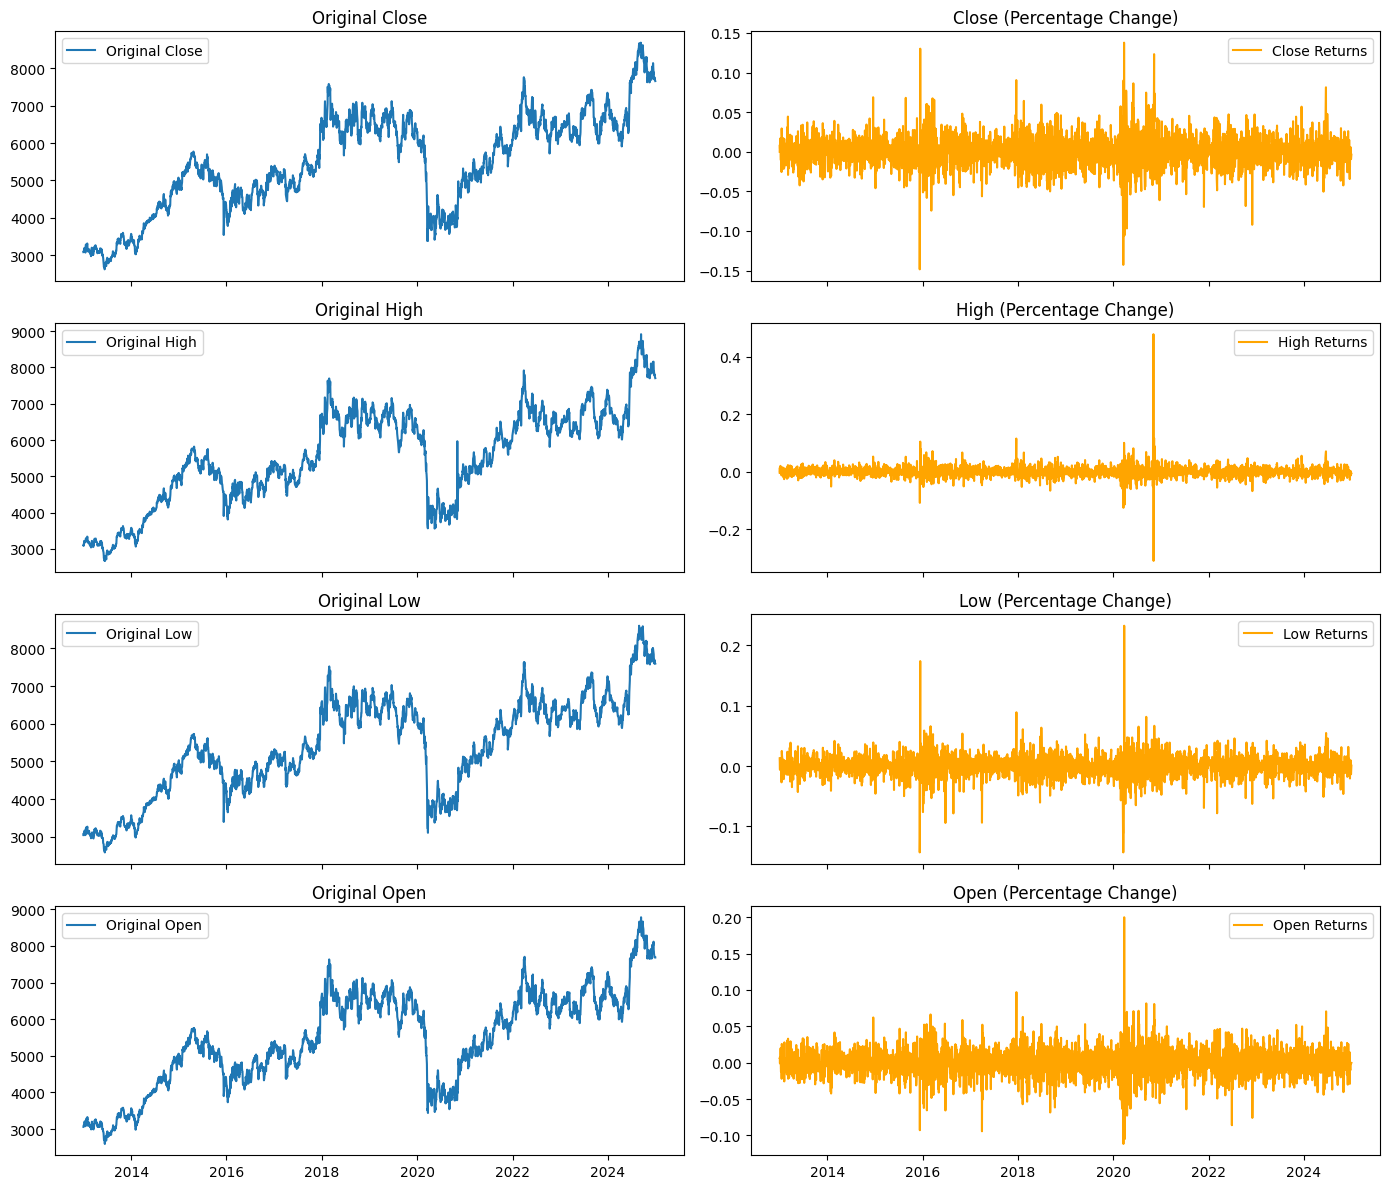

In [5]:
n_features = len(features)
fig, axes = plt.subplots(n_features, 2, figsize=(14, 3*n_features), sharex=True)

for i, col in enumerate(features):

    axes[i,0].plot(data2[col], label=f"Original {col}")
    axes[i,0].set_title(f"Original {col}")
    axes[i,0].legend()

    axes[i,1].plot(data_returns[col], label=f"{col} Returns", color='orange')
    axes[i,1].set_title(f"{col} (Percentage Change)")
    axes[i,1].legend()

plt.tight_layout()
plt.show()

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

# ==============================
# Scale Features (X) and Target (y)
# ==============================
X_scaler = StandardScaler()
y_scaler = StandardScaler()

# Scale X
X_train_scaled = X_scaler.fit_transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# Scale y (reshape to 2D before scaling, then flatten back)
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1,1)).ravel()

# ==============================
# Train SVR on scaled data
# ==============================
svr = SVR(kernel='rbf', C=10, gamma=0.01, epsilon=0.01)
svr.fit(X_train_scaled, y_train_scaled)

# Predict on test set
y_pred_scaled = svr.predict(X_test_scaled)

# Inverse transform predictions back to original scale
y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1,1)).ravel()

In [9]:
# ==============================
# Support Vector Regressor (SVR) Model
# ==============================
svr = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1)
svr.fit(X_train_scaled, y_train_scaled)

# ==============================
# Predictions
# ==============================
y_pred_scaled = svr.predict(X_test_scaled)

# Inverse transform predictions back to original scale
y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

# ==============================
# Evaluation
# ==============================
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\n🔹 Support Vector Regressor (SVR) Model Evaluation")
print("MSE:", mse)
print("R²:", r2)


🔹 Support Vector Regressor (SVR) Model Evaluation
MSE: 6.388700451526604e-05
R²: 0.7254227695133725


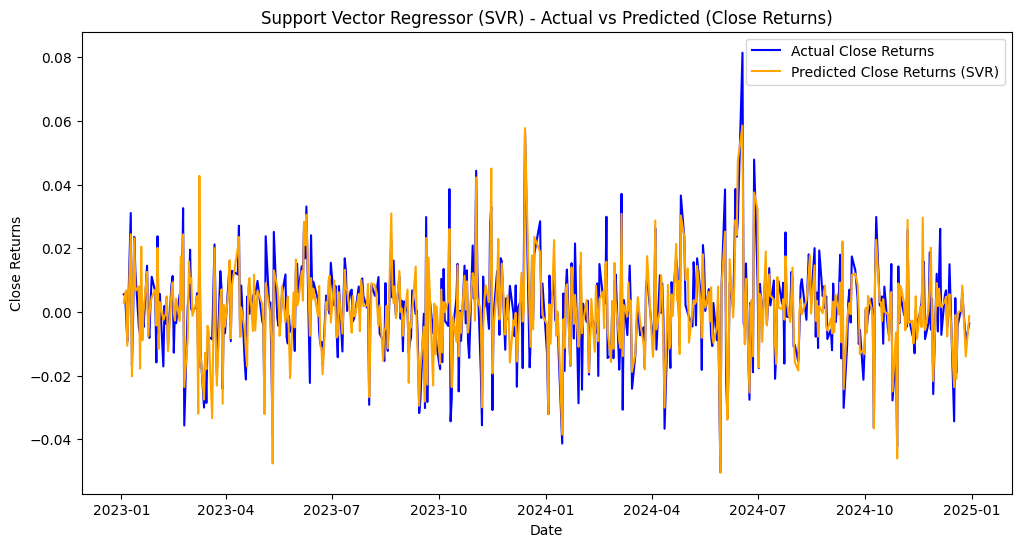

In [10]:
# ==============================
# Visualise Actual vs Predicted
# ==============================
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(y_test.index, y_test, label="Actual Close Returns", color="blue")
plt.plot(y_test.index, y_pred, label="Predicted Close Returns (SVR)", color="orange")

plt.title("Support Vector Regressor (SVR) - Actual vs Predicted (Close Returns)")
plt.xlabel("Date")
plt.ylabel("Close Returns")
plt.legend()
plt.show()


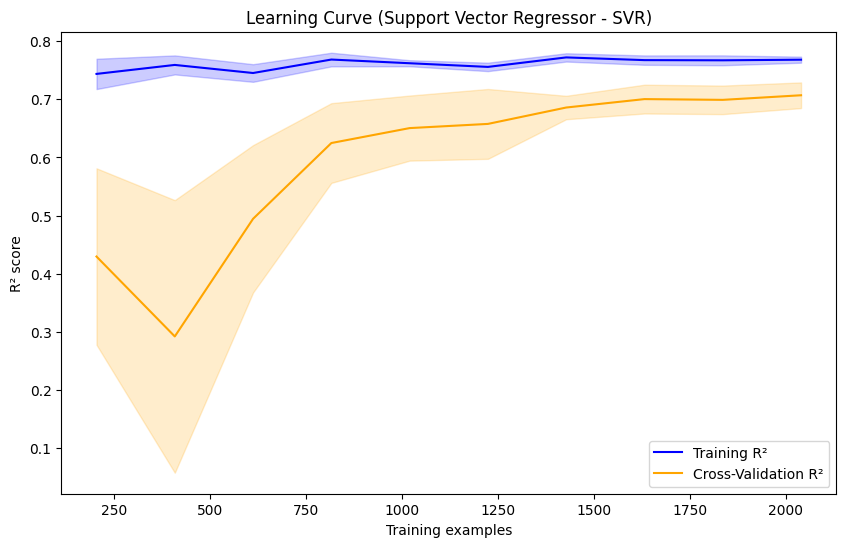

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.svm import SVR

# ==============================
# Define SVR model
# ==============================
svr_model = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1)

# ==============================
# Generate learning curve (use scaled data)
# ==============================
train_sizes, train_scores, test_scores = learning_curve(
    estimator=svr_model,
    X=X_train_scaled,   # use scaled X
    y=y_train_scaled,   # use scaled y
    cv=5,               # 5-fold cross validation
    scoring="r2",       # use R² score
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1
)

# ==============================
# Calculate mean and std
# ==============================
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# ==============================
# Plot Learning Curve
# ==============================
plt.figure(figsize=(10,6))
plt.plot(train_sizes, train_mean, label="Training R²", color="blue")
plt.plot(train_sizes, test_mean, label="Cross-Validation R²", color="orange")

plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, alpha=0.2, color="blue")
plt.fill_between(train_sizes, test_mean-test_std, test_mean+test_std, alpha=0.2, color="orange")

plt.title("Learning Curve (Support Vector Regressor - SVR)")
plt.xlabel("Training examples")
plt.ylabel("R² score")
plt.legend(loc="best")
plt.show()

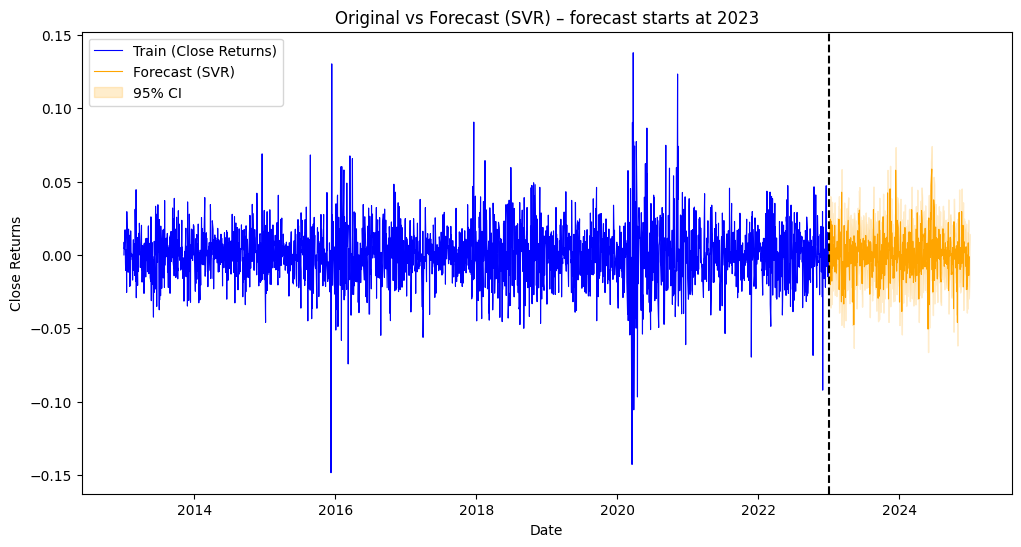

In [12]:
# ==============================
# Forecast with actual date index
# ==============================

# Error and confidence interval (make sure y_pred is inverse transformed)
error = y_test.values - y_pred
err_std = np.std(error)
lower = y_pred - 1.96 * err_std
upper = y_pred + 1.96 * err_std

plt.figure(figsize=(12,6))

# Training data (blue) – use actual index
plt.plot(y_train.index, y_train.values, label="Train (Close Returns)", color="blue", linewidth=0.8)

# Forecast (orange) – align with test index
plt.plot(y_test.index, y_pred, label="Forecast (SVR)", color="orange", linewidth=0.8)

# Confidence Interval
plt.fill_between(y_test.index, lower, upper, color="orange", alpha=0.2, label="95% CI")

# Vertical line at boundary (start of test set)
plt.axvline(x=y_test.index[0], color="k", linestyle="--")

# Labels and legend
plt.title("Original vs Forecast (SVR) – forecast starts at 2023")
plt.xlabel("Date")
plt.ylabel("Close Returns")
plt.legend()
plt.show()

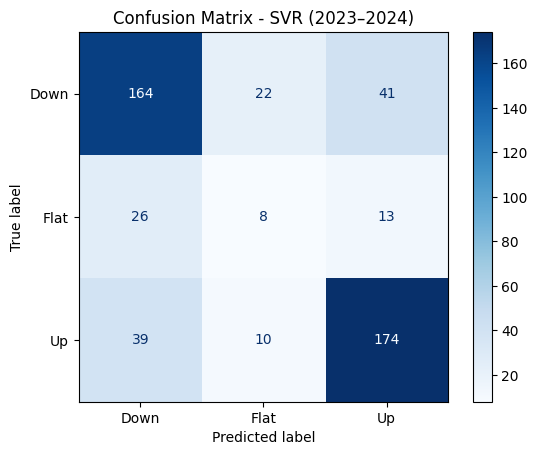

Classification Report - SVR
              precision    recall  f1-score   support

        Down       0.72      0.72      0.72       227
        Flat       0.20      0.17      0.18        47
          Up       0.76      0.78      0.77       223

    accuracy                           0.70       497
   macro avg       0.56      0.56      0.56       497
weighted avg       0.69      0.70      0.69       497



In [13]:

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Ensure arrays ---
y_test_arr = np.array(y_test).flatten()
y_pred_arr = np.array(y_pred).flatten()

# --- 2. Convert regression outputs into classes ---
def to_class(delta, eps=None):
    """
    Convert price changes into classes:
    +1 = Up, -1 = Down, 0 = Flat (within epsilon threshold)
    """
    if eps is None:
        eps = 0.1 * np.std(delta)  # threshold based on std deviation

    cls = np.zeros_like(delta, dtype=int)
    cls[delta > eps] = 1    # Up
    cls[delta < -eps] = -1  # Down
    return cls

# --- 3. Compute daily differences ---
delta_true = np.diff(y_test_arr, prepend=y_test_arr[0])
delta_pred = np.diff(y_pred_arr, prepend=y_pred_arr[0])

# --- 4. Convert differences to classes ---
true_cls = to_class(delta_true)
pred_cls = to_class(delta_pred)

# --- 5. Confusion Matrix ---
labels = [-1, 0, 1]  # Down, Flat, Up
cm = confusion_matrix(true_cls, pred_cls, labels=labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Down", "Flat", "Up"])
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - SVR (2023–2024)")
plt.show()

# --- 6. Classification Report ---
print("Classification Report - SVR")
print(classification_report(true_cls, pred_cls, target_names=["Down", "Flat", "Up"]))

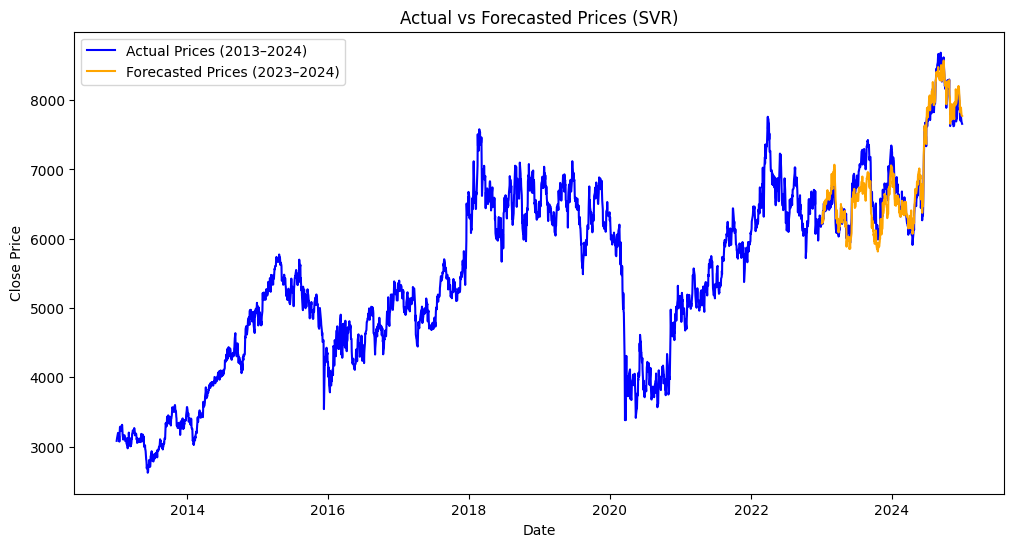

In [17]:
# ==============================
# 1. Reconstruct ACTUAL prices from returns (2013–2024)
# ==============================
p0 = data2["Close"].iloc[0]  # first actual price in 2013
reconstructed_prices = (1 + data_returns["Close"]).cumprod() * p0

# ==============================
# 2. Reconstruct FORECASTED prices from returns (2023–2024)
# ==============================
last_price_2022 = data2.loc[data2.index < "2023-01-01", "Close"].iloc[-1]  # last actual before forecast

forecast_prices = (1 + pd.Series(y_pred, index=y_test.index)).cumprod() * last_price_2022

# ==============================
# 3. Plot Actual vs Forecasted
# ==============================
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))

# Actual reconstructed prices
plt.plot(reconstructed_prices.index, reconstructed_prices,
         label="Actual Prices (2013–2024)", color="blue")

# Forecasted prices
plt.plot(forecast_prices.index, forecast_prices,
         label="Forecasted Prices (2023–2024)", color="orange")

plt.title("Actual vs Forecasted Prices (SVR)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()

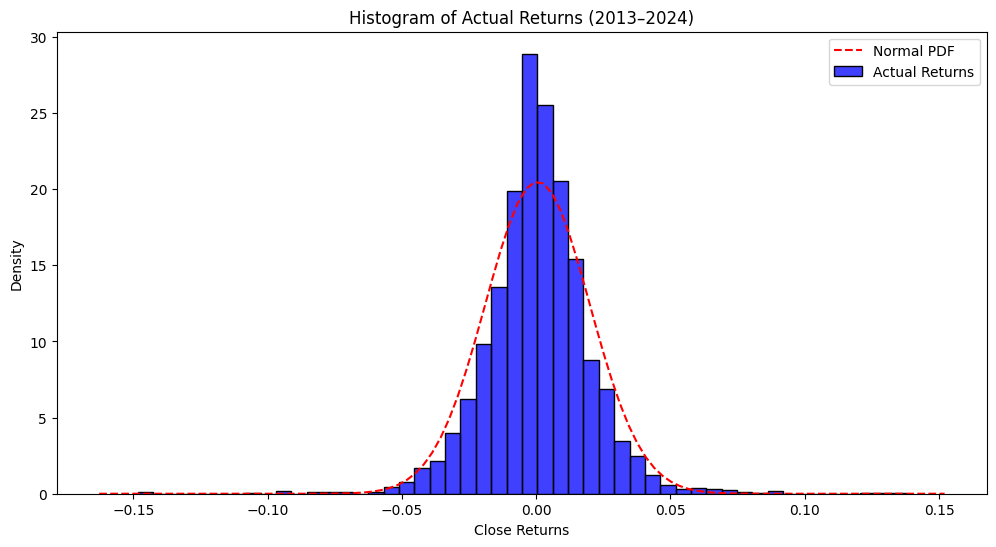

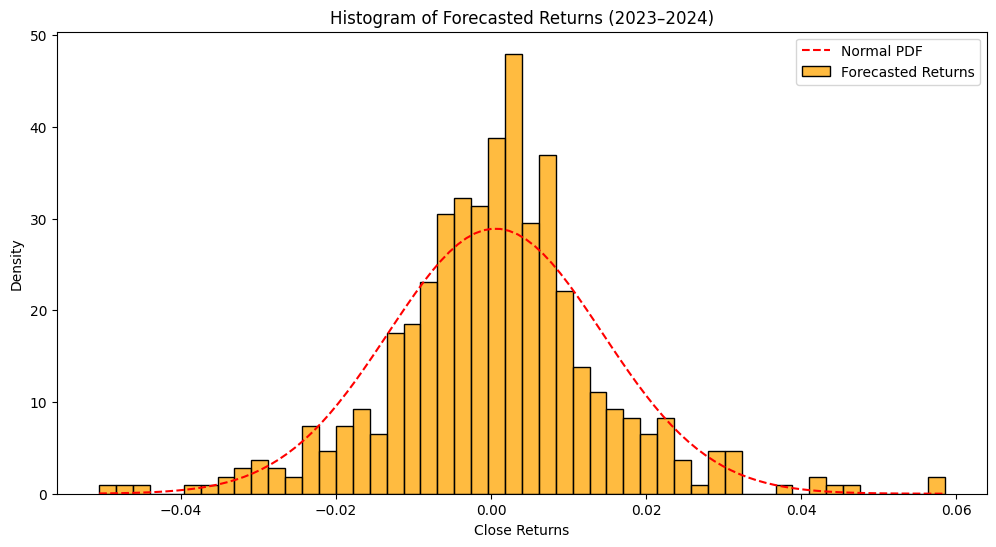

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np

# ==============================
# Histogram of ACTUAL returns (2013–2024)
# ==============================
plt.figure(figsize=(12,6))
sns.histplot(data_returns["Close"], bins=50, kde=False, color="blue", stat="density", label="Actual Returns")

# Fit and plot normal PDF
mu, std = stats.norm.fit(data_returns["Close"].dropna())
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, std)
plt.plot(x, p, "r--", label="Normal PDF")

plt.title("Histogram of Actual Returns (2013–2024)")
plt.xlabel("Close Returns")
plt.ylabel("Density")
plt.legend()
plt.show()

# ==============================
# Histogram of FORECASTED returns (2023–2024)
# ==============================
plt.figure(figsize=(12,6))
sns.histplot(y_pred, bins=50, kde=False, color="orange", stat="density", label="Forecasted Returns")

# Fit and plot normal PDF
mu, std = stats.norm.fit(y_pred)
x = np.linspace(min(y_pred), max(y_pred), 100)
p = stats.norm.pdf(x, mu, std)
plt.plot(x, p, "r--", label="Normal PDF")

plt.title("Histogram of Forecasted Returns (2023–2024)")
plt.xlabel("Close Returns")
plt.ylabel("Density")
plt.legend()
plt.show()